In [1]:
import numpy as np
from matplotlib import pyplot as plt
from IPython import display

import torch
from torch.utils.data import Dataset, DataLoader

from data import H5Dataset
from models import FCN, Encoder
from torch_pendulum import Pendulum

Given running cost $g(x_t,u_t)$ and terminal cost $h(x_T)$ the finite horizon $(t=0 \ldots T)$ optimal control problem seeks to find the optimal control, 
$$u^*_{1:T} = \text{argmin}_{u_{1:T}} L(x_{1:T},u_{1:T})$$ 
$$u^*_{1:T} = \text{argmin}_{u_{1:T}} h(x_T) + \sum_{t=0}^T g(x_t,u_t)$$
subject to the dynamics constraint: $x_{t+1} = f(x_t,u_t)$.

This notebook provides a dirty, brute forcing solution to problems of this form, using the inverted pendulum as an example, and assuming dynamics are not know a-priori. First, we gather state, actions, next state pairs, and use these to train a surrogate neural network dynamics model, $x_{t+1} \sim \hat{f}(x_t,u_t)$, approximating the true dynamics $f$.

We'll then set up a sampling-based optimiser (CEM) to train a policy $u^*_t \sim p(x_t)$ by rolling out using the surrogate dynamics $\hat{f}$, evaluating the cost. We'll do this in a continuous control setting, but again no stability guarantees. Miguel has a great description of CEM: https://jaques.xyz/cem-and-posterior/

In [2]:
# NN parameters
Nsamples = 10000
epochs = 500

latent_dim = 1024
batch_size = 8
lr = 3e-4

# Torch environment wrapping gym pendulum
torch_env = Pendulum()

# Test parameters
Nsteps = 100

In [3]:
# Set up model (fully connected neural network)

model = FCN(latent_dim=latent_dim,d=torch_env.d,ud=torch_env.ud)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [4]:
# Load previously trained model
model.load_state_dict(torch.load('./fcn.npy'))

<All keys matched successfully>

In [ ]:
# Or gather some training data
states_, actions, states = torch_env.get_data(Nsamples)

dset = H5Dataset(np.array(states_),np.array(actions),np.array(states))
sampler = DataLoader(dset, batch_size=batch_size, shuffle=True)

In [ ]:
# and train model

losses = []
for epoch in range(epochs):
    
    batch_losses = []
    for states_,actions,states in sampler:
        
        recon_x = model(states_,actions)
        loss = model.loss_fn(recon_x,states)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        batch_losses.append(loss.item())
    
    losses.append(np.mean(batch_losses))
    plt.cla()
    plt.semilogy(losses)
    
    display.clear_output(wait=True)
    display.display(plt.gcf())

In [ ]:
torch.save(model.state_dict(),'./fcn.npy')

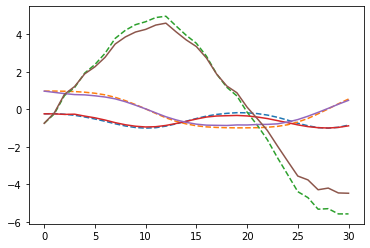

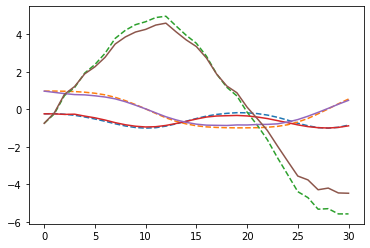

In [5]:
# Test model rollouts - looks reasonable

states = []
_states = []

s = torch_env.env.reset()
states.append(s)
_states.append(s.copy())
for i in range(30):
    a = torch_env.env.action_space.sample()
    s,r,_,_ = torch_env.env.step(a) # take a random action
    states.append(s)
    
    # roll-out with model
    _s = model(torch.from_numpy(_states[-1]).float().reshape(1,-1),torch.from_numpy(a).float().reshape(1,-1))
    _states.append(_s.detach().numpy())
    
    plt.cla()
    plt.plot(np.array(states),'--')
    plt.plot(np.vstack(_states))
    
    display.clear_output(wait=True)
    display.display(plt.gcf())

In [7]:
# Set up policy
policy = Encoder(latent_dim=latent_dim,hidden_dim=torch_env.ud)

# Load previously trained model
# policy.load_state_dict(torch.load('./CEM_policy.npy'))

In [8]:
class CEMControl:
    
    def __init__(self,dynamics,running_cost,term_cost,policy,u_dim=1,umax=2,frac=5,horizon=10,lr=1e-4):
        
        self.dynamics = dynamics
        self.term_cost = term_cost
        self.running_cost = running_cost
        self.horizon = horizon
        self.u_dim = u_dim
        self.umax = umax
        self.lr = lr
        self.frac = frac
        self.policy = policy
        self.optimizer = torch.optim.Adam(self.policy.parameters(), lr=self.lr)
        

    def cost(self,x):
        cost = []
        states = [x]
        controls = []
        with torch.no_grad():
            for j in range(self.horizon-1):
                mu_u = self.policy(states[-1])
                u = mu_u + torch.randn(1,1)
                states.append(self.dynamics(states[-1].reshape(1,-1),self.umax*torch.tanh(u).reshape(1,-1)))
                cost.append(self.running_cost(states[-1].reshape(1,-1),self.umax*torch.tanh(u).reshape(1,-1)))
                controls.append(u)

        return torch.sum(torch.stack(cost))+self.term_cost(states[-1],u[:,-1]), controls
    
    def minimize(self,xin,Ns=10):
        
        # Sample a bunch of trials using dynamics and policy
        losses = []
        controls = []
        for i in range(Ns):
            loss, u = self.cost(xin)
            
            losses.append(loss)
            controls.append(u[0])
            
        # Update policy
        
        mu_u = self.policy(xin) # Current action
        
        
        # Weight actions
        weights = -torch.stack(losses).reshape(-1,)
        weights = weights-torch.min(weights)
        weights = weights/torch.sum(weights)
        
        # Get top self.frac% actions and compute new best action
        idxs = torch.argsort(weights,dim=-1,descending=True)
        
        mu_new = torch.mean(torch.stack([controls[idx] for idx in idxs[:int(Ns/self.frac)]]).reshape(-1,self.u_dim))
        
        # Step in the direction of this better action
        loss = (mu_u-mu_new)**2
            
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        return self.umax*torch.tanh(mu_new), loss.item()


In [9]:
policy_learner = CEMControl(model.dynamics, torch_env.running_cost, torch_env.term_cost, policy,u_dim=1,umax=2,horizon=10,lr=1e-4)

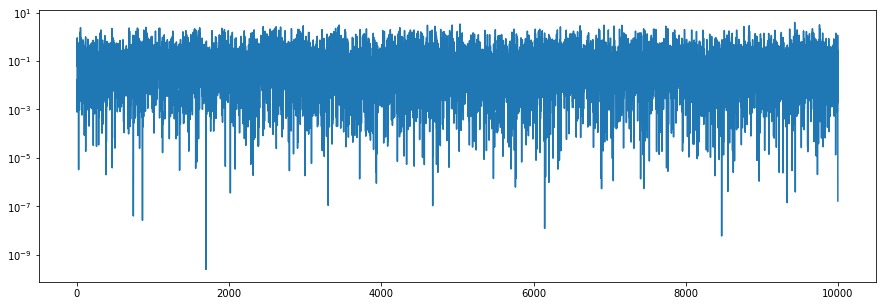

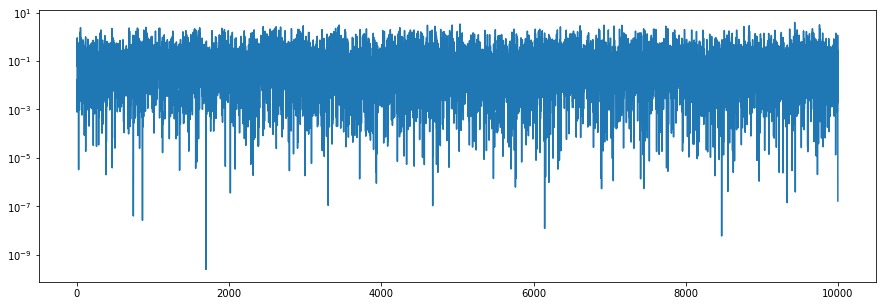

In [46]:
# Train controller
plt.figure(figsize=(15,5))
s = torch_env.env.reset()
losses = []
for i in range(10000):
    
    s = torch_env.env.observation_space.sample()
    u,loss = policy_learner.minimize(torch.from_numpy(s).reshape(1,-1).float(),Ns=50) #OC
    
    s,r,_,_ = torch_env.env.step([u.detach().numpy()]) # take a random action
    losses.append(loss)
    
    # Test policy every 100 steps
    if (i%100==0):
        s = torch_env.env.reset()
        
        for k in range(150):
            
            mu_u = policy(torch.from_numpy(s).reshape(1,-1).float())
            s,r,_,_ = torch_env.env.step(2*torch.tanh(mu_u).detach().numpy()) # take a random action
            torch_env.env.render()
    
    plt.clf()
    plt.semilogy(losses)
    
    display.clear_output(wait=True)
    display.display(plt.gcf())

In [45]:
torch.save(policy.state_dict(),'./CEM_policy.npy')

In [60]:
# Test policy
s = torch_env.env.reset()
for k in range(200):

    mu_u = policy(torch.from_numpy(s).reshape(1,-1).float())
    s,r,_,_ = torch_env.env.step(2*torch.tanh(mu_u).detach().numpy()) # take a random action
#     print(mu_u)
    torch_env.env.render()

In [61]:
torch_env.env.close()